# Electric Vehicle Ownership
Explore the trends behind EV ownership in WA state.

In [155]:
# import the basics
import numpy as np
import pandas as pd
import re
import missingno as msno

# plotting-related imports
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib
matplotlib.style.use('ggplot')

# mapping-related imports
import folium
import requests
import geocoder # import geocoder
import branca

from datetime import datetime
# Import time series modeling tools (ARIMA, Prophet)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

# import tools for model evaluation
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# settings to view full dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# EV ownership
This shows records of title activity (transactions recording changes of ownership), and registration activity (transactions authorizing vehicles to be used on Washington public roads). Data includes transactions completed January 2010 through February 2021.

[Source](https://data.wa.gov/Transportation/Electric-Vehicle-Title-and-Registration-Activity/rpr4-cgyd)

In [156]:
# read in data
new_title = pd.read_csv('./Data/new_title.csv')

## Plot each vehicle registration location

In [157]:
# drop null values
map_title = new_title.dropna(subset=['lat','lng','base_msrp']) # drop null values

# keep only lat and long values inside WA state

# limits of WA state coodinates
geo = {"min_lat": 45.5439,
    "max_lat": 49.0027,
    "min_lng": -124.8679,
    "max_lng": -116.9165}

map_title = map_title[(map_title['lat']>geo['min_lat']) & (map_title['lat']<geo['max_lat'])] # drop latitudes outside WA state
map_title = map_title[(map_title['lng']>geo['min_lng']) & (map_title['lng']<geo['max_lng'])] # drop longitudes outside WA state

In [158]:
map_title.head(2)

,vehicle_type,vin,model_year,make,model,new_or_used_vehicle,sale_price,dol_transaction_date,transaction_type,transaction_year,electric_vehicle_fee_paid,county,city,zip,electric_range,base_msrp,2015_hb_2778_exemption_eligibility,sale_date,vehicle_primary_use,state_of_residence,dol_vehicle_id,legislative_district,2019_hb_2042_clean_alternative_fuel_vehicle_(cafv)_eligibility,meets_2019_hb_2042_electric_range_requirement,meets_2019_hb_2042_sale_date_requirement,meets_2019_hb_2042_sale_price/value_requirement,odometer_reading,odometer_code,transportation_electrification_fee_paid,hybrid_vehicle_electrification_fee_paid,lat,lng
0,Battery Electric Vehicle (BEV),1N4AZ0CP5E,2014,NISSAN,LEAF,Used,8403,May 04 2017,Transfer Title,2017,Not Applicable,Whatcom,BELLINGHAM,98225.0,84,28980.0,TRANSACTION NOT ELIGIBLE: Not a new vehicle,February 28 2017,Passenger,WA,210160730,42.0,TRANSACTION NOT ELIGIBLE: Sale before August 2019,True,False,True,17979,Actual Mileage,Not Applicable,Not Applicable,48.750940,-122.501286
1,Battery Electric Vehicle (BEV),1N4AZ0CP1D,2013,NISSAN,LEAF,Used,12312016,January 23 2017,Transfer Title,2017,Not Applicable,King,SHORELINE,98155.0,75,28800.0,TRANSACTION NOT ELIGIBLE: Not a new vehicle,December 31 2016,Passenger,WA,221188747,32.0,TRANSACTION NOT ELIGIBLE: Sale before August 2019; TRANSACTION NOT ELIGIBLE: Sale price too high,True,False,False,27738,Actual Mileage,Not Applicable,Not Applicable,47.754413,-122.300477


In [159]:
map_title.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110163 entries, 0 to 110380
Data columns (total 32 columns):
 #   Column                                                          Non-Null Count   Dtype  
---  ------                                                          --------------   -----  
 0   vehicle_type                                                    110163 non-null  object 
 1   vin                                                             110163 non-null  object 
 2   model_year                                                      110163 non-null  int64  
 3   make                                                            110163 non-null  object 
 4   model                                                           110163 non-null  object 
 5   new_or_used_vehicle                                             110163 non-null  object 
 6   sale_price                                                      110163 non-null  int64  
 7   dol_transaction_date                  

Only 4 out of 31 columns have null values, for features that we're not particularly interested in.

In [160]:
map_title.describe()

,model_year,sale_price,transaction_year,zip,electric_range,base_msrp,dol_vehicle_id,legislative_district,odometer_reading,lat,lng
count,110163.000000,1.101630e+05,110163.000000,110163.000000,110163.000000,110163.000000,1.101630e+05,110159.000000,110163.000000,110163.000000,110163.000000
mean,2016.431361,2.944299e+04,2017.579287,98240.068744,132.488376,41156.647745,2.059609e+08,30.594150,9903.689270,47.493774,-122.115706
std,2.593590,4.802248e+04,2.281799,289.221379,95.565446,17412.509480,1.179557e+08,14.643637,18588.826556,0.583449,0.941121
min,1993.000000,0.000000e+00,2010.000000,97053.000000,6.000000,0.000000,4.000000e+00,1.000000,0.000000,45.557757,-124.635404
25%,2014.000000,0.000000e+00,2016.000000,98050.000000,53.000000,30433.590308,1.271316e+08,21.000000,19.000000,47.405479,-122.394409
50%,2017.000000,2.669800e+04,2018.000000,98116.000000,84.000000,35000.000000,1.838784e+08,35.000000,50.000000,47.618337,-122.280394
75%,2018.000000,4.809250e+04,2019.000000,98339.000000,215.000000,41350.000000,2.613870e+08,43.000000,15639.000000,47.716513,-122.123973
max,2021.000000,1.231202e+07,2021.000000,99403.000000,390.000000,845000.000000,4.792548e+08,49.000000,665500.000000,48.991930,-117.075344


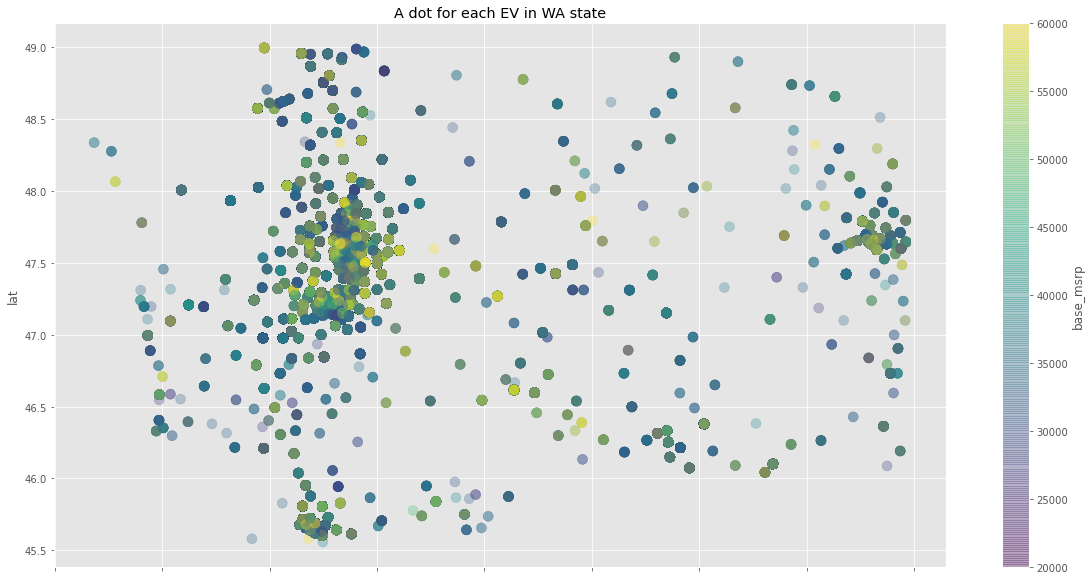

In [161]:
# convert 'zip' to type int
map_title['zip'] = map_title['zip'].astype(int)

# plot each location on an x-y plot, colored by base_msrp
# we did this in class with Caroline once
map_title.plot(kind="scatter", x="lng", y="lat", c="base_msrp",
         cmap="viridis", figsize=(20, 10), s=100, alpha=0.3, vmin=20000, vmax=60000);
plt.title('A dot for each EV in WA state')
plt.show()

## Cities with 15 largest EV counts

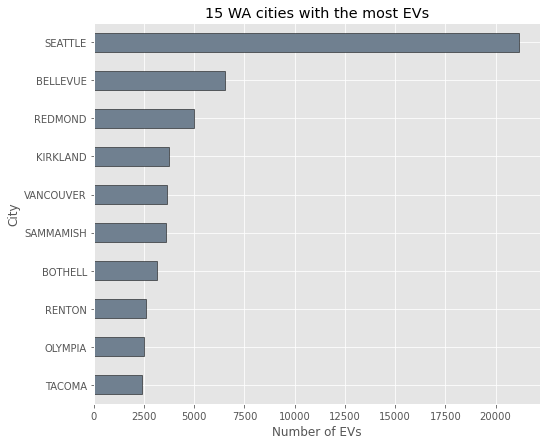

In [162]:
df_city = map_title.groupby(by='city')['vin'].count()

plt.figure(figsize=(8,7))
df_city.sort_values(ascending=True)[-10:].plot(kind='barh',color='slategray',edgecolor='black')
plt.xlabel('Number of EVs')
plt.ylabel('City')
plt.title('15 WA cities with the most EVs')
plt.show()

In [163]:
map_title['county'].value_counts(normalize=True).sort_values(ascending=False)[:5]

King         0.553503
Snohomish    0.107596
Pierce       0.075571
Clark        0.051942
Thurston     0.035194
Name: county, dtype: float64

55% of these vehicles are in King County (where Seattle is). This matches the dot density in the x-y map above.

## EV number by year

In [164]:
df_year.sort_values(ascending=True)

transaction_year
2010       26
2011     1202
2012     1931
2021     4134
2013     4987
2014     5481
2015     6814
2016     9541
2017    13593
2020    19448
2018    20467
2019    22539
Name: model, dtype: int64

In [165]:
df_year = map_title.groupby(by='transaction_year')['model'].count()
df_year

transaction_year
2010       26
2011     1202
2012     1931
2013     4987
2014     5481
2015     6814
2016     9541
2017    13593
2018    20467
2019    22539
2020    19448
2021     4134
Name: model, dtype: int64

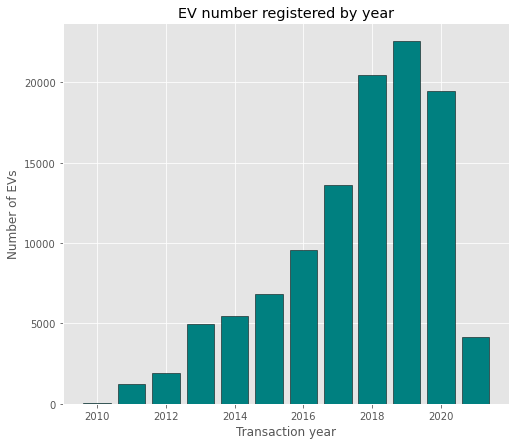

In [166]:
# visualize bar graph
plt.figure(figsize=(8,7))
plt.bar(x=df_year.index,height=df_year, color='teal',edgecolor='black')
plt.xlabel('Transaction year')
plt.ylabel('Number of EVs')
plt.title('EV number registered by year')
plt.show()

The registrations for 2020 dropped down, presumably covid-related.

### Drill down further into EV number
Vehicles that are resold should only be counted once. Strategy:
* sort by unique dol_vehicle_id then sort by transaction_date
* pick out only the 1st unique dol_vehicle_id

In [167]:
unique_ev = map_title.sort_values(by=['dol_vehicle_id','transaction_year'])
unique_ev.shape

(110163, 32)

In [168]:
unique_ev.drop_duplicates(subset=['dol_vehicle_id'], keep='first', inplace=True)
unique_ev.shape

(83816, 32)

We dropped ~30000 duplicates.

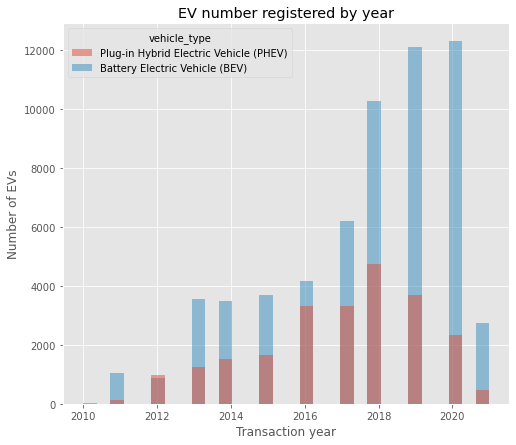

In [169]:
# replot bar graph, split by vehicle_type
unique_year = unique_ev.groupby(by='transaction_year')['vin'].count()

plt.figure(figsize=(8,7))
sns.histplot(data=unique_ev, x='transaction_year', hue='vehicle_type', stat='count', edgecolor=None, bins=30)
plt.xlabel('Transaction year')
plt.ylabel('Number of EVs')
plt.title('EV number registered by year')
plt.show()

Over time, sales grow, with BEV sales growing at a faster rate.

## Vehicle type

In [170]:
map_title['vehicle_type'].value_counts()

Battery Electric Vehicle (BEV)            77968
Plug-in Hybrid Electric Vehicle (PHEV)    32195
Name: vehicle_type, dtype: int64

## Range

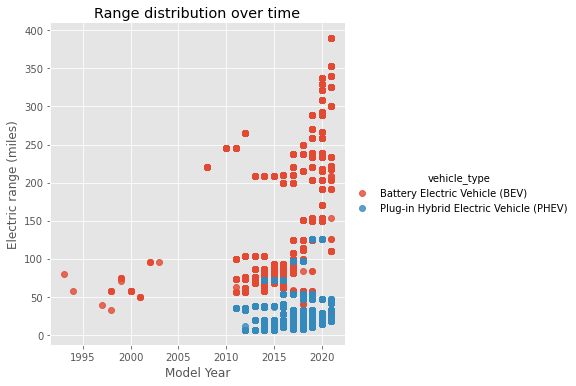

In [171]:
# look at electric range vs model year
sns.lmplot(x='model_year', y='electric_range', data=map_title, fit_reg=False, hue='vehicle_type')

plt.xlabel('Model Year')
plt.ylabel('Electric range (miles)')
plt.title('Range distribution over time')
plt.show()

In [172]:
# were vehicles in early 2000s really BEVs?
# yes, mostly Ford Ranger factory-made EV, some RAV 4 EV, Dodge Caravans

map_title[map_title['model_year']<2005].head(3)

,vehicle_type,vin,model_year,make,model,new_or_used_vehicle,sale_price,dol_transaction_date,transaction_type,transaction_year,electric_vehicle_fee_paid,county,city,zip,electric_range,base_msrp,2015_hb_2778_exemption_eligibility,sale_date,vehicle_primary_use,state_of_residence,dol_vehicle_id,legislative_district,2019_hb_2042_clean_alternative_fuel_vehicle_(cafv)_eligibility,meets_2019_hb_2042_electric_range_requirement,meets_2019_hb_2042_sale_date_requirement,meets_2019_hb_2042_sale_price/value_requirement,odometer_reading,odometer_code,transportation_electrification_fee_paid,hybrid_vehicle_electrification_fee_paid,lat,lng
1523,Battery Electric Vehicle (BEV),1FTZR081XY,2000,FORD,RANGER,Used,1500,December 18 2017,Original Title,2017,Not Applicable,King,SEATTLE,98125,58,1072.083333,TRANSACTION NOT ELIGIBLE: Not a new vehicle; CANNOT DETERMINE ELIGIBILITY: Base MSRP has not been determined,December 15 2017,Truck,WA,166281790,46.0,TRANSACTION NOT ELIGIBLE: Sale before August 2019,True,False,True,0,"Exempt - Over 10 years old, non-powered, or by use type",Not Applicable,Not Applicable,47.716513,-122.295829
1791,Battery Electric Vehicle (BEV),1FTZR081XY,2000,FORD,RANGER,Used,400,July 02 2020,Original Title,2020,Not Applicable,King,SEATTLE,98117,58,1072.083333,TRANSACTION NOT ELIGIBLE: Not a new vehicle; TRANSACTION NOT ELIGIBLE: Sale after 5/31/2018; CANNOT DETERMINE ELIGIBILITY: Base MSRP has not been determined,August 28 2019,Truck,WA,112660334,36.0,Clean Alternative Fuel Vehicle,True,True,True,0,"Exempt - Over 10 years old, non-powered, or by use type",Not Applicable,Not Applicable,47.687761,-122.384870
3550,Battery Electric Vehicle (BEV),1FTZR1073W,1998,FORD,RANGER,Used,0,April 16 2010,Original Title,2010,Not Applicable,Whatcom,BELLINGHAM,98225,58,1072.083333,TRANSACTION NOT ELIGIBLE: Not a new vehicle; TRANSACTION NOT ELIGIBLE: Transaction before 7/15/2015; CANNOT DETERMINE ELIGIBILITY: Base MSRP has not been determined,NaN,Truck,WA,5880752,42.0,TRANSACTION NOT ELIGIBLE: Sale before August 2019; CAUTION: Sale price not available,True,False,False,0,"Exempt - Over 10 years old, non-powered, or by use type",NaN,NaN,48.750940,-122.501286


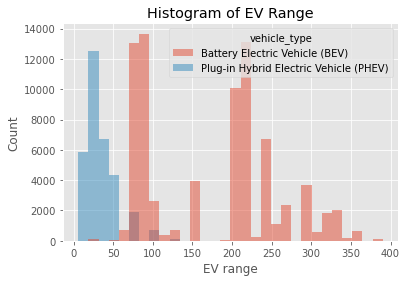

In [173]:
# look at EV range
sns.histplot(data=map_title, x='electric_range', hue='vehicle_type', stat='count', edgecolor=None, bins=30)
plt.xlabel('EV range')
plt.ylabel('Count')
plt.title('Histogram of EV Range')
plt.show()

PHEV range is clustered around 30 miles. BEV range is clustered around 70 miles and ~250 miles. These numbers match the production numbers online.

## MSRP

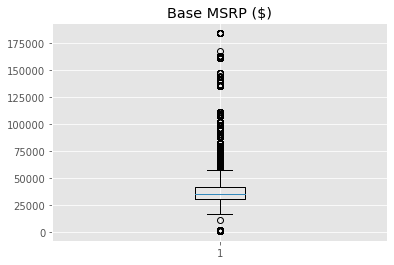

In [174]:
df_msrp = map_title[(map_title['base_msrp']>0) & (map_title['base_msrp']<845000)]

plt.boxplot(df_msrp['base_msrp'])
plt.title('Base MSRP ($)')
plt.show()

In [175]:
df_msrp['base_msrp'].median()

35000.0

That is still a huge price distribution. Median price of \\$35,000 is ~1.5X the average price of a gas vehicle (\$21,000) [[source]](https://theicct.org/sites/default/files/publications/EV_cost_2020_2030_20190401.pdf).

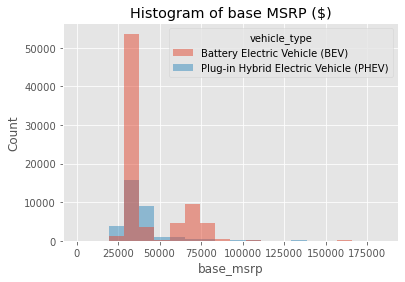

In [176]:
# Histogram of base MSRP
sns.histplot(data=df_msrp, x='base_msrp', hue='vehicle_type', stat='count', edgecolor=None, bins=20)
plt.title('Histogram of base MSRP ($)')
plt.show()

And in fact, the price distribution seems to have 2 clusters, centered around \\$33k, and \\$70k. Does the binary price distribution match the binary range distribution?

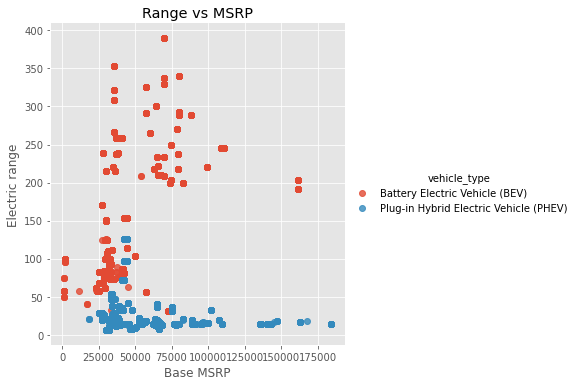

In [177]:
# Scatter plot: electric range vs base msrp

sns.lmplot(x='base_msrp', y='electric_range', data=df_msrp, fit_reg=False, hue='vehicle_type')
plt.xlabel('Base MSRP')
plt.ylabel('Electric range')
plt.title('Range vs MSRP')
plt.show()

There are maybe 4 clusters (2 within each vehicle type):
1. BEV:
    * low price, low range
    * medium price, high range
2. PHEV
    * low-medium price, low range
    * high price, low range (the power of brands)

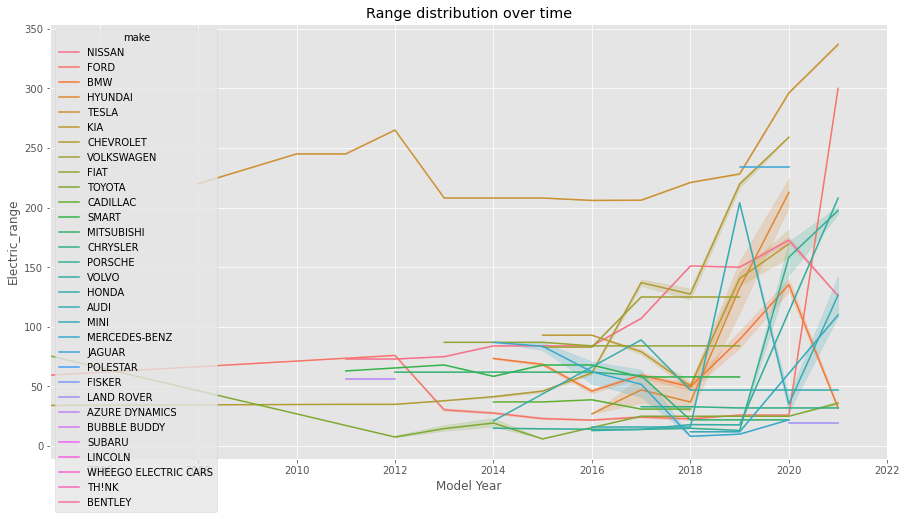

In [178]:
# plot range distribution over time
plt.figure(figsize=[15,8])
sns.lineplot(data=df_msrp, x="model_year", y="electric_range", hue="make")
plt.xlabel('Model Year')
plt.ylabel('Electric_range')
plt.title('Range distribution over time')
plt.xlim([2005, 2022])
plt.show()

Generically, range has been increasing especially these last few years.

# Time Series Modeling
## 1. ARIMA

In [179]:
ev_mo = map_title[['dol_transaction_date']] # pull out transaction date
ev_mo['sale'] = 1 # 1 sale per transaction date

# create 'date' column that has datetime type
ev_mo['date'] = pd.to_datetime(ev_mo['dol_transaction_date'])

# set index to date column
ev_mo = ev_mo.set_index('date').sort_index()

<ipython-input-179-18641bc53444>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev_mo['sale'] = 1 # 1 sale per transaction date
<ipython-input-179-18641bc53444>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev_mo['date'] = pd.to_datetime(ev_mo['dol_transaction_date'])


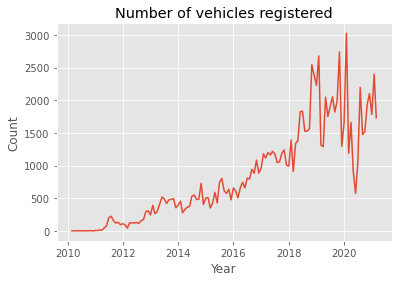

In [180]:
# resample by month end frequency
# https://stackoverflow.com/questions/17001389/pandas-resample-documentation

ev_mo_r = ev_mo.resample('M').sum()
plt.plot(ev_mo_r)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Number of vehicles registered')
plt.show()

* The registration info swings more wildly starting 2018 onwards.
* Sales dropped in early 2020, possibly skewing our projections. 

In [181]:
# create first_diff and second_diff columns
ev_mo_r['first_diff'] = ev_mo_r['sale'].diff()
ev_mo_r['second_diff'] = ev_mo_r['first_diff'].diff()

# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [182]:
# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(ev_mo_r['sale']))

Test Statistic   -0.382710
p-value           0.912946
dtype: float64

In [183]:
# Run the ADF test on our once-differenced data.
interpret_dftest(adfuller(ev_mo_r['first_diff'].dropna()))

Test Statistic   -5.315083
p-value           0.000005
dtype: float64

In [184]:
# Run the ADF test on our second-differenced data.
interpret_dftest(adfuller(ev_mo_r['second_diff'].dropna()))

Test Statistic   -6.715476e+00
p-value           3.591192e-09
dtype: float64

H_0: not stationary, H_A: stationary

Non-differenced data has a high p-value, so cannot reject null hypothesis

First-differenced data has p-value < 0.005, so we reject the null hypothesis i.e. our data is stationary. For an ARIMA model, we set d = 1.

Second-differenced data is not necessary

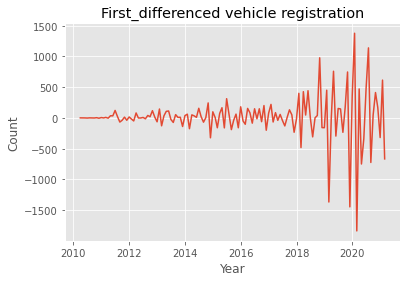

In [185]:
# plot first-differenced values
plt.plot(ev_mo_r['first_diff'])
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('First_differenced vehicle registration')
plt.show()

Those wild swings past 2018 are very visible.

In [186]:
# Create train-test split.
# 0.9 for train, 0.1 for test
y_train, y_test = train_test_split(ev_mo_r['sale'], test_size=0.1, shuffle=False) 

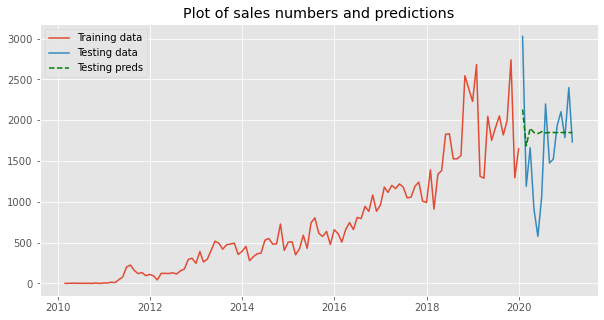

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   sale   No. Observations:                  119
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -807.745
Date:                Thu, 15 Apr 2021   AIC                           1625.489
Time:                        07:16:31   BIC                           1639.343
Sample:                    02-28-2010   HQIC                          1631.114
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7485      0.155     -4.840      0.000      -1.052      -0.445
ar.L2         -0.2437      0.148     -1.645      0.100      -0.534       0.047
ma.L1          0.2329      0.155      1.498      0.134      -0.072       0.538
ma.L2         -0.4050      0.149     -2.714      0.007      -0.697      -0.113
sigma2      5.137e+04   3807.839     13.491      0.000    4.39e+04    5.88e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               504.37
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):              34.70   Skew:                            -0.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [187]:
# try an ARIMA model with some p, q
arima_model = ARIMA(endog=y_train, order=(2,1,2)).fit()

test_start = y_test.index[0]
test_end = y_test.index[-1]

arima_preds = arima_model.predict(start=test_start, end=test_end)

plt.figure(figsize=(10,5))
plt.title('Plot of sales numbers and predictions')
plt.plot(y_train, label='Training data')
plt.plot(y_test, label='Testing data')
plt.plot(arima_preds, '--', label='Testing preds',color='green')
plt.legend()
plt.show()

display(arima_model.summary())

In [188]:
print(f'RMSE for first ARIMA attempt: {np.sqrt(mean_squared_error(y_test, arima_preds))}')

RMSE for first ARIMA attempt: 596.0735567036855


### Manual GridSearch

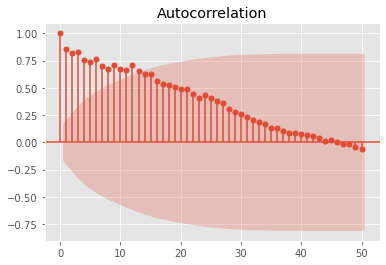

In [189]:
plot_acf(ev_mo_r['sale'], lags=50);

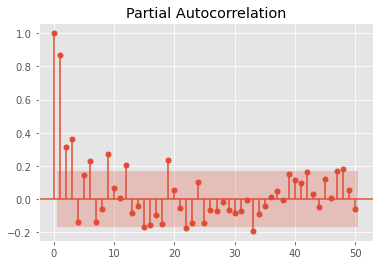

In [190]:
plot_pacf(ev_mo_r['sale'], lags=50);

Maybe we should use 4 lags? Try gridsearch.

In [191]:
# Starting AIC, p, and q.
best_aic = 99*(10**16) # start with a crazy huge number
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):

        
        # Insert try and except statements.
        try:
            
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting to fit ARIMA({p}, 1, {q})')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog=y_train, order=(p, 1, q)).fit()
            

            # Print out AIC for ARIMA(p, 1, q) model.
#             print(f'The AIC for ARIMA({p},1,{q}) is: {arima.aic}')

            # Is my current model's AIC better than our best_aic?
            if arima.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = arima.aic
                best_p = p
                best_q = q

        except:
            print(f"Error with p={p}, q={q}")
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0, 1, 0)
Attempting to fit ARIMA(0, 1, 1)
Attempting to fit ARIMA(0, 1, 2)
Attempting to fit ARIMA(0, 1, 3)
Attempting to fit ARIMA(0, 1, 4)
Attempting to fit ARIMA(1, 1, 0)
Attempting to fit ARIMA(1, 1, 1)
Attempting to fit ARIMA(1, 1, 2)
Attempting to fit ARIMA(1, 1, 3)
Attempting to fit ARIMA(1, 1, 4)
Attempting to fit ARIMA(2, 1, 0)
Attempting to fit ARIMA(2, 1, 1)
Attempting to fit ARIMA(2, 1, 2)
Attempting to fit ARIMA(2, 1, 3)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Attempting to fit ARIMA(2, 1, 4)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Attempting to fit ARIMA(3, 1, 0)
Attempting to fit ARIMA(3, 1, 1)
Attempting to fit ARIMA(3, 1, 2)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Attempting to fit ARIMA(3, 1, 3)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Attempting to fit ARIMA(3, 1, 4)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Attempting to fit ARIMA(4, 1, 0)
Attempting to fit ARIMA(4, 1, 1)
Attempting to fit ARIMA(4, 1, 2)
Attempting to fit ARIMA(4, 1, 3)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Attempting to fit ARIMA(4, 1, 4)


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(2,1,4).
This model has an AIC of 1603.4218842338275.


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


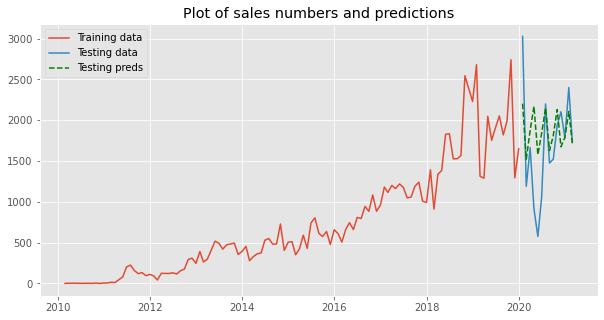

In [192]:
# refit with optimized parameters
arima_model = ARIMA(endog=y_train, order=(2,1,4)).fit()

test_start = y_test.index[0]
test_end = y_test.index[-1]

arima_preds = arima_model.predict(start=test_start, end=test_end)

plt.figure(figsize=(10,5))
plt.title('Plot of sales numbers and predictions')
plt.plot(y_train, label='Training data')
plt.plot(y_test, label='Testing data')
plt.plot(arima_preds, '--', label='Testing preds',color='green')
plt.legend()
plt.show()

In [193]:
print(f'RMSE for ARIMA attempt, with optimized p, d, q: {np.sqrt(mean_squared_error(y_test, arima_preds))}')

RMSE for ARIMA attempt, with optimized p, d, q: 563.3581868997749


This has a lower RMSE, and visually it looks like a better fit because it has some variation over time. Let's use the whole dataset for training, and forecast 5 years into the future.

/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


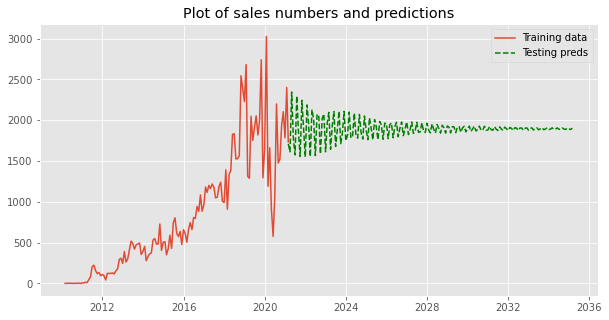

In [194]:
y_train_all = ev_mo_r['sale']

new_model = ARIMA(endog=y_train_all, order=(2,1,4)).fit()

test_start = y_train_all.index[-1]
test_end = datetime(2035, 2, 28)

new_preds = new_model.predict(start=test_start, end=test_end)

plt.figure(figsize=(10,5))
plt.title('Plot of sales numbers and predictions')
plt.plot(y_train_all, label='Training data')
# plt.plot(y_test, label='Testing data')
plt.plot(new_preds, '--', label='Testing preds',color='green')
plt.legend()
plt.show()

Over time, the prediction settles to a mean. And looks like the wild swings after 2018 removes the climbing sales pattern. Let's try smoothing before fitting to see if this improves predictions.

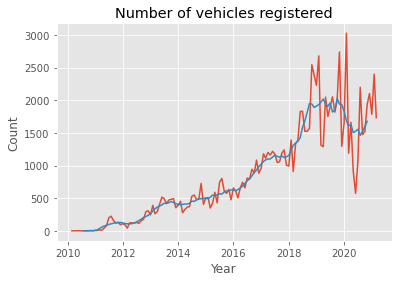

In [195]:
# Plot rolling average
plt.plot(ev_mo_r['sale'], label='Data')
plt.plot(ev_mo_r['sale'].rolling(10, center=True).mean(), label='10-month rolling average \n centered')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Number of vehicles registered')
plt.show()

The dip in registration starting at the end of 2019 is still visible. Let's try truncating the dataset first, to Jan 2020 (just before Covid started affecting global trade), before fitting.

In [196]:
ev_trunc = ev_mo_r.iloc[:-13,:]

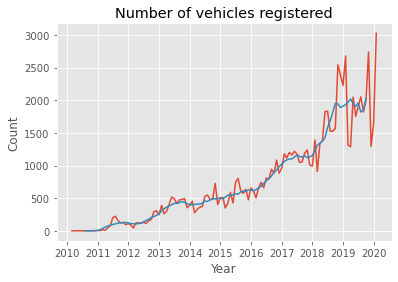

In [197]:
# Replot rolling average
plt.plot(ev_trunc['sale'], label='Data')
plt.plot(ev_trunc['sale'].rolling(10, center=True).mean(), label='10-month rolling average \n centered')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Number of vehicles registered')
plt.show()

In [198]:
# Create train-test split.
# 0.9 for train, 0.1 for test
y_train, y_test = train_test_split(ev_trunc['sale'], test_size=0.1, shuffle=False) 

In [199]:
# Starting AIC, p, and q.
best_aic = 99*(10**16) # start with a crazy huge number
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):

        
        # Insert try and except statements.
        try:
            
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting to fit ARIMA({p}, 1, {q})')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog=y_train, order=(p, 1, q)).fit()
            

            # Print out AIC for ARIMA(p, 1, q) model.
#             print(f'The AIC for ARIMA({p},1,{q}) is: {arima.aic}')

            # Is my current model's AIC better than our best_aic?
            if arima.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = arima.aic
                best_p = p
                best_q = q

        except:
            print(f"Error with p={p}, q={q}")
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0, 1, 0)
Attempting to fit ARIMA(0, 1, 1)
Attempting to fit ARIMA(0, 1, 2)
Attempting to fit ARIMA(0, 1, 3)
Attempting to fit ARIMA(0, 1, 4)
Attempting to fit ARIMA(1, 1, 0)
Attempting to fit ARIMA(1, 1, 1)
Attempting to fit ARIMA(1, 1, 2)
Attempting to fit ARIMA(1, 1, 3)
Attempting to fit ARIMA(1, 1, 4)
Attempting to fit ARIMA(2, 1, 0)
Attempting to fit ARIMA(2, 1, 1)
Attempting to fit ARIMA(2, 1, 2)
Attempting to fit ARIMA(2, 1, 3)
Attempting to fit ARIMA(2, 1, 4)
Attempting to fit ARIMA(3, 1, 0)
Attempting to fit ARIMA(3, 1, 1)
Attempting to fit ARIMA(3, 1, 2)
Attempting to fit ARIMA(3, 1, 3)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Attempting to fit ARIMA(3, 1, 4)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Attempting to fit ARIMA(4, 1, 0)
Attempting to fit ARIMA(4, 1, 1)
Attempting to fit ARIMA(4, 1, 2)
Attempting to fit ARIMA(4, 1, 3)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Attempting to fit ARIMA(4, 1, 4)


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(1,1,3).
This model has an AIC of 1392.3543274564784.


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The best model uses (p,d,q) of (1,1,3).

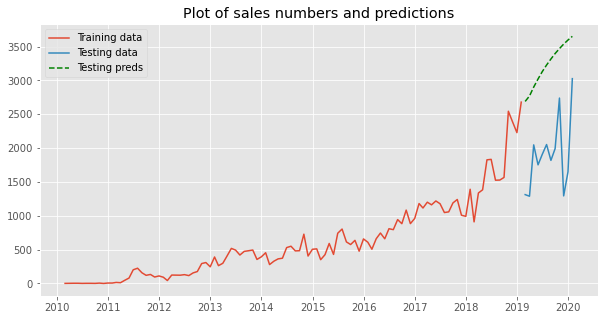

In [200]:
# refit with optimized parameters
arima_model = ARIMA(endog=y_train, order=(1,1,3)).fit()

test_start = y_test.index[0]
test_end = y_test.index[-1]

arima_preds = arima_model.predict(start=test_start, end=test_end)

plt.figure(figsize=(10,5))
plt.title('Plot of sales numbers and predictions')
plt.plot(y_train, label='Training data')
plt.plot(y_test, label='Testing data')
plt.plot(arima_preds, '--', label='Testing preds',color='green')
plt.legend()
plt.show()

In [201]:
print(f'RMSE for ARIMA model on smoothed data: {np.sqrt(mean_squared_error(y_test, arima_preds))}')

RMSE for ARIMA model on smoothed data: 1392.8188430311009


Well that's a great trend to have, upwards and to the right! But it's way off the actual test values (4X previous RMSEs). Let's still try and use the whole dataset to train the model, then forecast into the next 5 years.

In [202]:
y_train_all = ev_trunc['sale']

# Starting AIC, p, and q.
best_aic = 99*(10**16) # start with a crazy huge number
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):

        
        # Insert try and except statements.
        try:
            
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting to fit ARIMA({p}, 1, {q})')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog=y_train_all, order=(p, 1, q)).fit()
            

            # Print out AIC for ARIMA(p, 1, q) model.
#             print(f'The AIC for ARIMA({p},1,{q}) is: {arima.aic}')

            # Is my current model's AIC better than our best_aic?
            if arima.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = arima.aic
                best_p = p
                best_q = q

        except:
            print(f"Error with p={p}, q={q}")
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0, 1, 0)
Attempting to fit ARIMA(0, 1, 1)
Attempting to fit ARIMA(0, 1, 2)
Attempting to fit ARIMA(0, 1, 3)
Attempting to fit ARIMA(0, 1, 4)
Attempting to fit ARIMA(1, 1, 0)
Attempting to fit ARIMA(1, 1, 1)
Attempting to fit ARIMA(1, 1, 2)
Attempting to fit ARIMA(1, 1, 3)
Attempting to fit ARIMA(1, 1, 4)
Attempting to fit ARIMA(2, 1, 0)
Attempting to fit ARIMA(2, 1, 1)
Attempting to fit ARIMA(2, 1, 2)
Attempting to fit ARIMA(2, 1, 3)
Attempting to fit ARIMA(2, 1, 4)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Attempting to fit ARIMA(3, 1, 0)
Attempting to fit ARIMA(3, 1, 1)
Attempting to fit ARIMA(3, 1, 2)
Attempting to fit ARIMA(3, 1, 3)
Attempting to fit ARIMA(3, 1, 4)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Attempting to fit ARIMA(4, 1, 0)
Attempting to fit ARIMA(4, 1, 1)
Attempting to fit ARIMA(4, 1, 2)
Attempting to fit ARIMA(4, 1, 3)


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Attempting to fit ARIMA(4, 1, 4)


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(4,1,3).
This model has an AIC of 1631.3238973785524.


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/aida/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


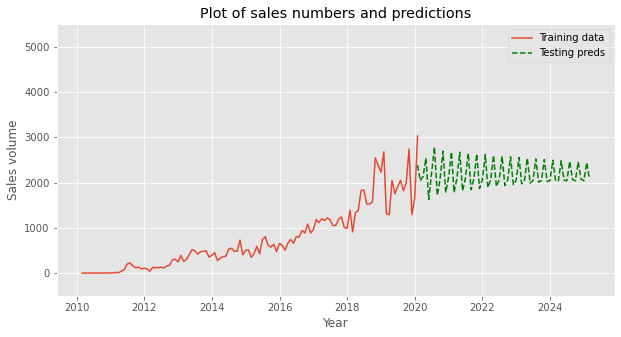

In [203]:
new_model = ARIMA(endog=y_train_all, order=(4,1,3)).fit()

test_start = y_train_all.index[-1]
test_end = datetime(2025, 2, 28)

new_preds = new_model.predict(start=test_start, end=test_end)

plt.figure(figsize=(10,5))
plt.title('Plot of sales numbers and predictions')
plt.plot(y_train_all, label='Training data')
# plt.plot(y_test, label='Testing data')
plt.plot(new_preds, '--', label='Testing preds',color='green')
plt.xlabel('Year')
plt.ylabel('Sales volume')
plt.ylim(-500,5500)
plt.legend()
plt.show()

The projections still fluctuate over time before settling to a mean. Compare with publisehd [DoE projections](https://www.energy.gov/sites/prod/files/2019/12/f69/GITT%20ISATT%20EVs%20at%20Scale%20Grid%20Summary%20Report%20FINAL%20Nov2019.pdf): DoE projections indicate growing numbers beyond 2020. Even the minimum sales mode has the count plateauing but it is expected to keep increasing over time. Let's try a different model - Facebook's Prophet.

<img src="./images/EV_sales_forecast.png" alt="EV sales forecast" style="width: 500px;"/>

## 2. Prophet model

In [204]:
# setup for Prophet
df_prophet = ev_trunc[['sale']]
df_prophet = df_prophet.reset_index()
df_prophet.columns=['ds','y']
df_prophet.head()

,ds,y
0,2010-02-28,1
1,2010-03-31,2
2,2010-04-30,3
3,2010-05-31,3
4,2010-06-30,1


In [205]:
# Create train-test split.
# 0.9 for train, 0.1 for test
y_train_p = df_prophet[:108]
y_test_p = df_prophet[108:]

In [206]:
# instantiate, fit, predict
m = Prophet()
m.fit(y_train_p)

future = y_test_p[['ds']]
forecast = m.predict(future)

forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
7,2019-09-30,2142.194678,1917.113202,2368.740133
8,2019-10-31,2359.606964,2138.244797,2567.264391
9,2019-11-30,2247.693843,2023.616199,2466.791093
10,2019-12-31,2306.178178,2104.615678,2510.715675
11,2020-01-31,2423.646485,2211.668330,2628.160678


<ipython-input-207-672181ad2026>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_p['yhat'] = list(forecast['yhat'])


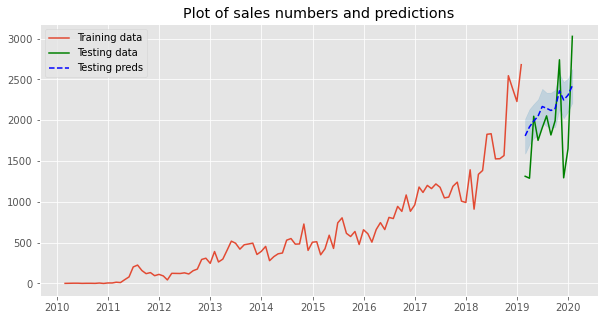

In [207]:
y_test_p['yhat'] = list(forecast['yhat'])

# Plot results
plt.figure(figsize=(10,5))
plt.title('Plot of sales numbers and predictions')
plt.plot(y_train_p['ds'], y_train_p['y'], label='Training data')
plt.plot(y_test_p['ds'], y_test_p['y'], label='Testing data',color='green')
plt.plot(y_test_p['ds'], y_test_p['yhat'], '--', label='Testing preds',color='blue')
plt.fill_between(y_test_p['ds'], forecast['yhat_lower'], forecast['yhat_upper'],color='C1',alpha=0.2)
plt.legend()
plt.show()

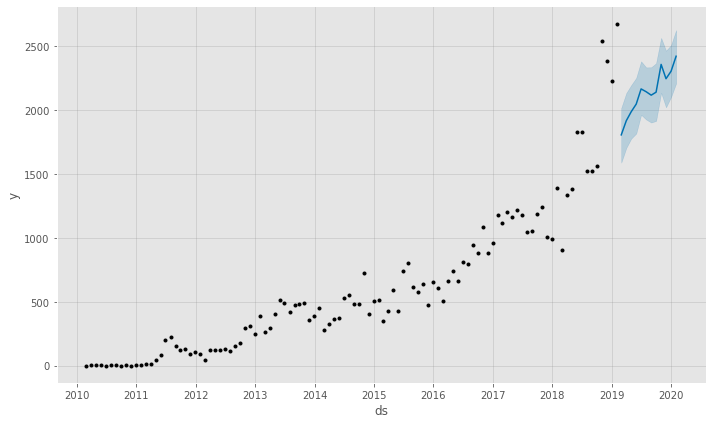

In [208]:
# built-in Prophet plotting
m.plot(forecast);

In [209]:
# calculate RMSE
print(f'RMSE from Prophet model: {np.sqrt(mean_squared_error(y_test_p["y"],y_test_p["yhat"]))}')

RMSE from Prophet model: 480.4325751834355


This is 3X lower than the ARIMA model applied to the smoothed data.

In [210]:
# Use whole dataset to train, then predict into the future
mall = Prophet()
mall.fit(df_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [211]:
df_prophet.head()

,ds,y
0,2010-02-28,1
1,2010-03-31,2
2,2010-04-30,3
3,2010-05-31,3
4,2010-06-30,1


In [212]:
futureall = mall.make_future_dataframe(periods=365*5)
futureall.tail()

,ds
1940,2025-01-25
1941,2025-01-26
1942,2025-01-27
1943,2025-01-28
1944,2025-01-29


In [213]:
forecastall = mall.predict(futureall)
forecastall[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1940,2025-01-25,4837.636458,4536.436122,5132.364916
1941,2025-01-26,4735.753182,4403.370708,5061.263170
1942,2025-01-27,4620.859363,4309.466150,4959.576307
1943,2025-01-28,4494.905192,4175.624160,4818.723704
1944,2025-01-29,4360.082060,4026.823812,4684.804297


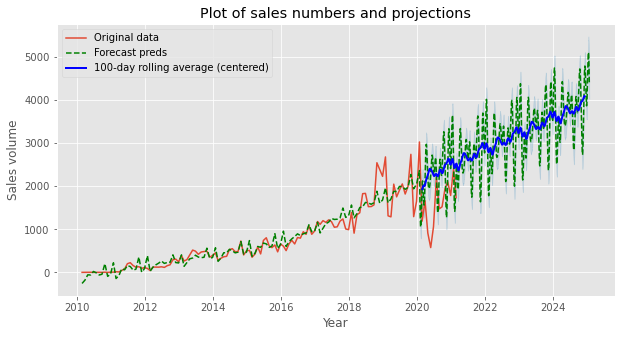

In [214]:
# Plot projections
plt.figure(figsize=(10,5))
plt.title('Plot of sales numbers and projections')
plt.plot(ev_mo_r['sale'], label='Original data')
plt.plot(forecastall['ds'],forecastall['yhat'], '--', label='Forecast preds',color='green')
plt.fill_between(forecastall['ds'][120:], forecastall['yhat_lower'][120:], forecastall['yhat_upper'][120:],color='C1',alpha=0.2)
plt.xlabel('Year')
plt.ylabel('Sales volume')

subsetx = forecastall['ds'][100:]
subsety = forecastall['yhat'][100:]

# 100-day rolling average, plot centered
plt.plot(subsetx, subsety.rolling(100, center=True).mean(), '-', color='blue', linewidth=2, label='100-day rolling average (centered)')
plt.legend()
plt.show()

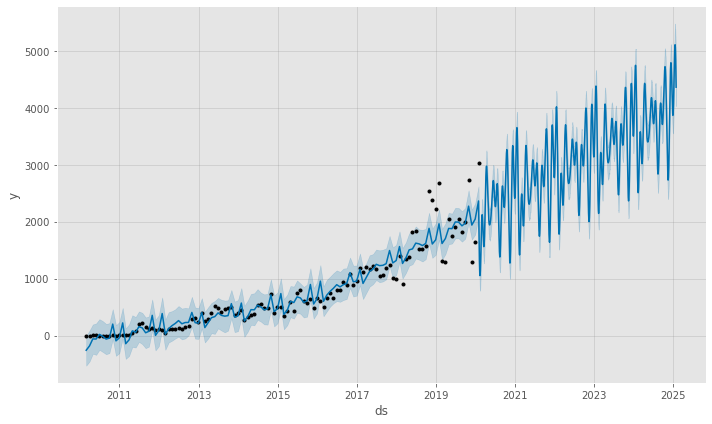

In [215]:
# inbuilt Prophet plotting tool
mall.plot(forecastall);

Next we'll look at EV distribution with economic markers.

In [216]:
# uncomment to save
# map_title.to_csv('./Data/map_title.csv', index=False)